<a href="https://colab.research.google.com/github/probabll/mixed-rv-vae/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%load_ext autoreload
#%autoreload 2

You will need to clone and install [probabll/dists.pt](https://github.com/probabll/dists.pt.git)

In [2]:
!git clone https://github.com/probabll/dists.pt.git

Cloning into 'dists.pt'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 153 (delta 14), reused 23 (delta 9), pack-reused 119
Receiving objects: 100% (153/153), 1.59 MiB | 21.48 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [3]:
cd dists.pt

/content/dists.pt


In [4]:
!git pull

Already up to date.


In [5]:
pip install .

Processing /content/dists.pt
  Created wheel for probabll.distributions: filename=probabll.distributions-1.0-cp37-none-any.whl size=27347 sha256=a3721821bdcab9461a29922e8ddbc835bc82110e4f55e81e3e6d49e650f37543
  Stored in directory: /tmp/pip-ephem-wheel-cache-zeedw6b8/wheels/57/1a/2b/f7ce4003f5bac13f5913d519a9aa2be4bf97f8a37496f3ecbe
Successfully built probabll.distributions


In [6]:
cd ..

/content


# Mixed RVs via Mixture of Dirichlets

In this notebook I develop a mixed rv on $\Delta_{K-1}$ via the so called *stratified representation*, that is, as a finite mixture of distributions on the faces of $K-1$-dimensional simplex.





## Stratified Representation


Let $Z$ be an rv taking on values in the simplex $\Delta_{K-1}$. The density assigned to an outcome $y \in \Delta_{K-1}$ is given by

\begin{align}
  p_{Y}(y|\alpha, \omega) &= \sum_{f} p_F(f|\omega) p_{Y|F}(y|f, \alpha) \\
  &= \sum_f \mathrm{Cat}(f|\omega) \mathrm{Dir}(y|\alpha_f)
\end{align}

where $f$ is a face of dimensionality $\mathrm{dim}(f)$ and we choose a $\mathrm{dim}(f)$-dimensional Dirichlet distribution for $Y|F=f$. There are $2^K-1$ non-empty faces, thus $\omega \in \Delta_{2^K-2}$. An efficient parameterisation of the Categorical distribution is possible (see notebook on using FSA to represent discrete distributions), but in this implementation we will assume the parameter $\omega$ can be stored/predicted explicitly. Similarly, the parameters $\alpha_f \in \mathbb R_{>0}^{\mathrm{dim}(f)}$ can be stored or predicted for all faces.


**Gradient estimation**

We assume samples from $Y|F=f, \alpha$ can be reparameterised in terms of samples from a fixed distribution $\Phi$ independent of $\alpha$, i.e. $\epsilon = \mathcal T^{-1}(y; \alpha_f) \sim \Phi$, 
and use score function estimation for gradient estimation with respect to $\omega$:

\begin{align}
    \nabla_{\alpha,\omega} \mathbb E_{Y|\alpha, \omega}\left[ \psi(z) \right] &= \nabla_{\omega} \mathbb E_{F|\omega}\left[ \nabla_{\alpha} \mathbb E_{Y|F,\alpha} \left[ \psi(z) \right] \right] \\
    &= \mathbb E_{F|\omega}\left[ \left( \nabla_{\alpha} \mathbb E_{Y|F,\alpha} \left[ \psi(z) \right] \right)\nabla_{\omega} \log p_F(f) \right] \\
    &= \mathbb E_{F|\omega}\left[  \mathbb E_{} \left[ \nabla_{y} \psi(y) \nabla_{\alpha_f} \mathcal T(\epsilon; \alpha_f) \right] \nabla_{\omega} \log p_F(f) \right]
\end{align}

For variance reduction we can use baselines based on summary statistics (e.g., mean, standard deviation), on trained MLPs, or based on $\nabla_{\alpha} \mathbb E_{Y|F,\alpha}[ \psi(y')]$ assessed at an additional sample $y'$ (this is known as  a self-critic). More sophisticated techniques are possible (but hopefully won't be needed).




In [7]:
import torch
torch.__version__

'1.8.1+cu101'

In [8]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd

# VAE

A variational auto-encoder approximates the distribution of $X$ on sample space $\mathcal X$ as a marginal of a joint distribution $X,Y|\theta$ whose pdf factorises $p_{XY}(x, y|\theta) = p_{Y}(y|\theta)p_{X|Y}(x|y, \theta)$. Inference employs an independently parameterised  approximation $Y|X=x, \lambda$ to the true posterior distribution $Y|X=x, \theta$. The parameters $\theta$ of the generative model and $\lambda$ of the inference model are estimated jointly to maximise a lowerbound on the log-evidence (the ELBO):

\begin{align}
\theta^\star, \theta^\star &= \arg\,\max_{\theta, \lambda} ~ \sum_{x \sim \mathcal D}\mathrm{ELBO}_x(\theta, \lambda) \\
&= \arg\,\max_{\theta, \lambda} ~ \sum_{x \sim \mathcal D} \mathbb E_{Y|X,\lambda}\left[ \log \frac{p_{XY}(x, y|\theta)}{q_{Y|X}(y|x, \lambda)} \right]
\end{align}

For us, $Y$ is a mixed rv, and we will use the stratified representation explained above. And, in this notebook, an observed data point $x$ is an MNIST digit, i.e., $x\in \{0, 1\}^{H\times W}$.

In [9]:
import torch.nn as nn


def assert_shape(t, shape, message):
    assert t.shape == shape, f"{message} has the wrong shape: got {t.shape}, expected {shape}"        


## Generative model

\begin{align}
p_{XYF}(x, y, f|\theta) &= p_{F}(f)p_{Y|F}(y|f, \theta)p_{X|Y}(x|y, \theta) \\
&= \mathrm{Gibbs}(f|\mathbf 0_K) \times \mathrm{Dir}(y|\mathbf 1_{\mathrm{dim}(f)}) \times \prod_{d=1}^D \mathrm{Bern}(x_d|b_d(x, y; \theta))
\end{align}

where the Gibbs distribution is constrained to supporting all but the empty face of $\Delta_{K-1}$, and $\mathbf b(x, y;\theta) \in (0,1)^D$ is the output of an NN with parameters $\theta$.


In [10]:
class GenerativeModel(nn.Module):

    def __init__(self, latent_dim, data_dim, hidden_dec_size):
        super().__init__()
        self._latent_dim = latent_dim    
        self._data_dim = data_dim   
        self._y_to_logits = nn.Sequential(
            nn.Linear(latent_dim, hidden_dec_size),
            nn.ReLU(),
            nn.Linear(hidden_dec_size, hidden_dec_size),
            nn.ReLU(),
            nn.Linear(hidden_dec_size, data_dim),
        )
        self.register_buffer("_prior_scores", torch.zeros(latent_dim, requires_grad=False))
 

    def F(self, predictors=None):
        """
        :param predictors: input predictors, this is reserved for future use
        """
        return pd.NonEmptyBitVector(scores=self._prior_scores)

    def Y(self, f, predictors=None):
        """
        :param f: face-encoding [batch_size, K]
        :param predictors: input predictors, this is reserved for future use
        """
        return pd.MaskedDirichlet(f.bool(), torch.ones_like(f))

    def X(self, y, predictors=None):
        logits = self._y_to_logits(y)
        return td.Independent(td.Bernoulli(logits=logits), 1)  
    
    def sample(self, sample_shape=torch.Size([])):
        # [sample_shape, K]
        f = self.F().sample(sample_shape)
        # [sample_shape, K]
        y = self.Y(f).sample()
        # [sample_shape, D]
        x = self.X(y).sample()
        return f, y, x
    
    def log_prob(self, f, y, x, per_bit=False):
        if per_bit:
            return self.F().log_prob(f), self.Y(f).log_prob(y), self.X(y).base_dist.log_prob(x)
        else:
            return self.F().log_prob(f), self.Y(f).log_prob(y), self.X(y).log_prob(x)
    

## Inference model

\begin{align}
q_{YF|X}(y,f|x,\lambda) &= q_{F|X}(f|x, \lambda) q_{Y|FX}(y|f,x, \lambda) \\
&= \mathrm{Gibbs}(f|\mathbf s(x; \lambda)) \times \mathrm{Dir}(y|\mathbf a(x, f;\lambda))
\end{align}

where $\mathbf s(x; \lambda) \in \mathbb R^K$ is a vector of scores predicted by an NN, and $\mathbf a(x, f; \lambda) \in \mathbb R_{>0}^{\mathrm{dim}(f)}$ is a vector of concentrations predicted by an NN; $\lambda$ denotes the NN parameters.

In [11]:
class InferenceModel(nn.Module):

    def __init__(self, latent_dim, data_dim, hidden_enc_size, cond='fx'):
        super().__init__()

        assert cond in {'f', 'x', 'fx'}, f"The concentration net can take 'f', 'x', or 'fx', got {cond}"
        self._cond = cond

        self._scores_net = nn.Sequential(
            nn.Linear(data_dim, hidden_enc_size),
            nn.ReLU(),
            nn.Linear(hidden_enc_size, hidden_enc_size),
            nn.ReLU(),
            nn.Linear(hidden_enc_size, latent_dim)
        )
        if cond == 'f':
            self._concentrations_net = nn.Sequential(
                nn.Linear(latent_dim, latent_dim),
                nn.ReLU(),
                nn.Linear(latent_dim // 2, latent_dim // 2),
                nn.ReLU(),
                nn.Linear(latent_dim // 2, latent_dim),
                nn.Softplus()
            )
        else: # x or fx
            self._concentrations_net = nn.Sequential(
                nn.Linear(data_dim if cond == 'f' else latent_dim + data_dim, hidden_enc_size),
                nn.ReLU(),
                nn.Linear(hidden_enc_size, hidden_enc_size),
                nn.ReLU(),
                nn.Linear(hidden_enc_size, latent_dim),
                nn.Softplus()
            )
            
    def F(self, x, predictors=None):
        # [B, K]
        scores = self._scores_net(x) 
        return pd.NonEmptyBitVector(scores)

    def Y(self, f, x, predictors=None):
        if self._cond == 'f':
            inputs = f  # [...,K]
        else:
            if len(f.shape) < len(x.shape):
                raise ValueError(f"f is missing dimensions: f has shape {f.shape} and x has shape {x.shape}")
            elif len(f.shape) > len(x.shape): 
                # deal with f having a larger sample_shape than x
                sample_dims = len(f.shape) - len(x.shape)
                sample_shape = f.shape[:sample_dims] 
                x = x.view((1,) * sample_dims + x.shape).expand(sample_shape + (-1,) * len(x.shape))
            if self._cond == 'x':
                inputs = x  # [...,D]
            else:
                assert f.shape[:-1] == x.shape[:-1], "f and x have different sample/batch shapes"
                inputs = torch.cat([f, x], -1)  # [...,K+D]
        # [...,K]
        concentration = self._concentrations_net(inputs) 
        return pd.MaskedDirichlet(f.bool(), concentration)
    
    def sample(self, x, sample_shape=torch.Size([])):
        # [sample_shape, B, K]
        f = self.F(x).sample(sample_shape)
        # [sample_shape, B, K]
        y = self.Y(f, x).sample()
        return f, y
    
    def log_prob(self, f, y, x):
        return self.F(x).log_prob(f), self.Y(f, x).log_prob(y)

## ELBO

For a single observation $x$, our ELBO corresponds to:

\begin{align}
\mathrm{ELBO}_x(\theta, \lambda) 
&=  \mathbb E_{F|X=x,\lambda} \mathbb E_{Y|X=x,\lambda}\left[ \log p_{X|Y}(x| y,\theta) \right]\\
&- \mathbb E_{F|X=x,\lambda}\left[ \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right] \\
&- \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )
\end{align}

A gradient estimator for $\theta$ can be obtained via
\begin{align}
\nabla_\theta \mathrm{ELBO}_x(\theta, \lambda)&\approx \nabla_\theta \log p_{X|Y}(x|y, \theta) \\
&- \nabla_\theta \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&- \nabla_\theta \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )
\end{align}
with $y,f \sim Y,F|X=x, \lambda$.

A gradient estimator for $\lambda$ can be obtained via
\begin{align}
\nabla_\lambda  \mathrm{ELBO}_x(\theta, \lambda) &\approx \nabla_{\lambda} \log p_{X|Y}(x|y=\mathcal T(\epsilon; \lambda), \theta) \\
&-\nabla_\lambda \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&-\nabla_\lambda \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta ) \\
&+\left( \log p_{X|Y}(x|y, \theta) -  \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right) \nabla_\lambda \log q_{F|X}(f|x,\lambda)
\end{align}
with $f \sim F|X=x,\lambda$ and $y = \mathcal T(\epsilon; \lambda)$ for $\epsilon \sim \Phi$.

A surrogate in `pytorch` is given by 
\begin{align}
&\log p_{X|Y}(x|y, \theta) \\
&- \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&- \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )\\
&+ \mathrm{detach}\left( \log p_{X|Y}(x|y, \theta) -  \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right) \log q_{F|X}(f|x,\lambda)
\end{align}
again with $f \sim F|X=x,\lambda$ and $y = \mathcal T(\epsilon; \lambda)$ for $\epsilon \sim \Phi$.

In [12]:
from collections import OrderedDict


class VAE:

    def __init__(self, p, q):
        self.p = p
        self.q = q

    def train(self):
        self.p.train()
        self.q.train()

    def eval(self):
        self.p.eval()
        self.q.eval()

    def gen_parameters(self):
        return self.p.parameters()

    def inf_parameters(self):
        return self.q.parameters()

    def loss(self, x_obs, reward_avg=0.0, reward_std=1.0):
        """
        :param x_obs: [B, D]
        """
        B, K, D = x_obs.shape[0], p._latent_dim, p._data_dim

        # [B, K]
        q_F = self.q.F(x_obs)
        f = q_F.sample()
        assert_shape(f, (B, K), "f ~ F|X=x, \lambda")
        q_Y = self.q.Y(f, x_obs)
        y = q_Y.rsample()
        assert_shape(y, (B, K), "y ~ Y|F=f, \lambda")
        
        p_F = self.p.F()
        if p_F.batch_shape != x_obs.shape[:1]:
            p_F = p_F.expand(x_obs.shape[:1] + p_F.batch_shape)
        
        p_Y = self.p.Y(f)  # we condition on f ~ q_F         
        p_X = self.p.X(y)  # we condition on y ~ q_Y

        # ELBO: the first term is an MC estimate (we sampled (f,y))
        # the second term is exact 
        # the third term is an MC estimate (we sampled f)
        ll = p_X.log_prob(x_obs)
        kl_Y_given_f = td.kl_divergence(q_Y, p_Y)
        kl_F = td.kl_divergence(q_F, p_F)
        
        # E_FY[ log p(x|y,f)] - KL(F) - E_F[ KL(Y) ]
        # E_F[ E_Y[  log p(x|y,f) ] - KL(Y) ] - KL(F)
        # E_F[ r(F) ] for r(f) = log p(x|y,f)
        # r(f).detach() * log q(f)
        base_reward = (ll - kl_Y_given_f).detach()
        reward = (base_reward - reward_avg) / np.minimum(reward_std, 1.0)
        sfe_surrogate = reward * q_F.log_prob(f)
        grep_surrogate = ll - kl_F - kl_Y_given_f
        loss = -(grep_surrogate + sfe_surrogate).mean(0)
        ret = OrderedDict(
            loss=loss.item(),
            LL=ll.mean(0).item(),
            KL_F=kl_F.mean(0).item(),
            KL_Y=kl_Y_given_f.mean(0).item(),
            SFE_base_reward_mean=base_reward.mean(0).item(),
            SFE_base_reward_std=base_reward.std(0).item(),
            SFE_reward_mean=reward.mean(0).item(),
            SFE_reward_std=reward.std(0).item(),
        )
        return loss, ret

    def estimate_ll(self, x_obs, num_samples):     
        with torch.no_grad():
            self.eval()
            
            # we unsqueeze so we can introduce a sample dimension.
            #x_obs = x_obs.unsqueeze(0)

            # log 1/K \sum_{k} p(x, z_k)/q(z_k|x)
            # [N, B, K]
            f, y = self.q.sample(x_obs, (num_samples,))
            # [N, B]
            log_p = torch.stack(self.p.log_prob(f, y, x_obs), -1).sum(-1)
            log_q = torch.stack(self.q.log_prob(f, y, x_obs), -1).sum(-1)
            # [B]
            ll = torch.logsumexp(log_p - log_q, 0) - np.log(num_samples)                    
        return ll

    def estimate_ll_per_bit(self, x_obs, num_samples):     
        
        with torch.no_grad():

            
            self.eval()
            
            # introduce a sample dimension
            #x_obs = x_obs.unsqueeze(0)

            # log 1/K \sum_{k} p(x, z_k)/q(z_k|x)
            # [N, B, K]
            f, y = self.q.sample(x_obs, (num_samples,))        
            # [N, B], [N, B], [N, B, D]
            log_pf, log_py, log_px = self.p.log_prob(f, y, x_obs, per_bit=True)
            # [N, B, D]
            log_p = log_pf.unsqueeze(-1) + log_py.unsqueeze(-1) + log_px
            # [N, B]
            log_q = torch.stack(self.q.log_prob(f, y, x_obs), -1).sum(-1)
            # [B, D]
            ll = torch.logsumexp(log_p - log_q.unsqueeze(-1), 0) - np.log(num_samples)
                    
        return ll

# MNIST 

* Download
* Preprocess
* Batcher

## Data and Batcher

In [13]:
import pathlib
import numpy as np
import torch
import torch.utils.data
from torchvision import datasets, transforms


def boolean_argument(string):
    return str(string).lower() in {"true", "yes", "1"}


def list_argument(dtype, separator=","):
    def constructor(string):
        return [dtype(x) for x in string.split(separator)]
    return constructor

def print_digit(matrix):
    rows = []
    for i in range(matrix.size(0)):
        row = ""
        for j in range(matrix.size(1)):
            row += "x" if matrix[i,j] >= 0.5 else " "
        rows.append(row)
    return "\n".join(rows)


def load_mnist(batch_size, save_to, height=28, width=28):
    """
    :param batch_size: the dataloader will create batches of this size
    :param save_to: a folder where we download the data into    
    :param height: using something other than 28 implies a Resize transformation
    :param width: using something other than 28 implies a Resize transformation
    :return: 3 data loaders
        training, validation, test
    """
    # create directory
    pathlib.Path(save_to).mkdir(parents=True, exist_ok=True)
    
    if height == width == 28:
        transform = transforms.ToTensor()    
    else:        
        transform = transforms.Compose([
            transforms.Resize((height, width)), 
            transforms.ToTensor()]
        )

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(
            datasets.MNIST(
                save_to,
                train=True, 
                download=True, 
                transform=transform),
            indices=range(55000)), 
        batch_size=batch_size,
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(
            datasets.MNIST(
                save_to,
                train=True, 
                download=True, 
                transform=transform),
            indices=range(55000, 60000)), 
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            save_to,
            train=False, 
            download=True, 
            transform=transform),
        batch_size=batch_size
    )
    return train_loader, valid_loader, test_loader


class Batcher:
    """
    Deals with options such as
        * dynamic binarization
        * change to device
        * shape
        * one-hot encoding of digits
    """
    
    def __init__(self, data_loader, height, width, device, binarize=False, onehot=False, num_classes=10): 
        self.data_loader = data_loader
        self.height = height
        self.width = width
        self.device = device
        self.binarize = binarize
        self.num_batches = len(data_loader)
        self.onehot = onehot
        self.num_classes = num_classes
            
    def __len__(self):
        return self.num_batches
    
    def __iter__(self):
        """        
        Yields
            x: [B, H, W], y: [B]
        or
            x: [B, H, W], y: [B, 10]
        """
        for x, y in self.data_loader: 
            # x: [B, C=1, H, W], y: [B]
            # [B, H, W]
            x = x.reshape(x.size(0), self.height, self.width).to(self.device)
            if self.binarize:
                x = (x > torch.rand_like(x)).float()
            # [B]
            y = y.to(self.device)
            if self.onehot:
                # [B, 10]
                y = torch.nn.functional.one_hot(y, num_classes=self.num_classes)
            yield x, y
                


## Hyperparameters

In [14]:
from collections import namedtuple
cfg = dict(
    batch_size=200,
    data_dir='tmp',
    height=28,
    width=28, 
    device='cuda:0',
    epochs=10,
    grad_clip=5.0,
    num_samples=1000,
    hidden_enc_size=500,
    hidden_dec_size=500,
    cond='fx',
    latent_dim=10,
)
args = namedtuple('Config', cfg.keys())(*cfg.values())

In [15]:
# You can skip this on Colab

# Download MNIST
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

In [16]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to='./', 
    height=args.height, 
    width=args.width
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [17]:
def get_batcher(data_loader, args):
    batcher = Batcher(
        data_loader, 
        height=args.height, 
        width=args.width, 
        device=torch.device(args.device), 
        binarize=True, 
        num_classes=10,
        onehot=True
    )
    return batcher

## Model

In [18]:
p = GenerativeModel(
    latent_dim=args.latent_dim, 
    data_dim=args.height * args.width, 
    hidden_dec_size=args.hidden_dec_size,
).to(torch.device(args.device))

In [19]:
q = InferenceModel(
    latent_dim=10, 
    data_dim=args.height * args.width, 
    hidden_enc_size=args.hidden_enc_size,
    cond=args.cond,
).to(torch.device(args.device))

In [20]:
q.sample(p.sample()[-1])

(tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 0.], device='cuda:0'),
 tensor([0.1101, 0.1454, 0.2292, 0.1113, 0.3417, 0.0000, 0.0000, 0.0622, 0.0000,
         0.0000], device='cuda:0'))

In [21]:
vae = VAE(p, q)

## Visualisations

* Compare statistics of samples from $p$ to those of samples from $q$
* Visualise a few generations

In [22]:
from matplotlib import pyplot as plt
from collections import defaultdict

In [23]:
def compare_p_q(vae, batcher: Batcher, args): 
    with torch.no_grad():
        vae.eval()        
    
        prior = defaultdict(list)
        posterior = defaultdict(list)
        num_obs = 0

        # Some visualisations
        for x_obs, y_obs in batcher:
            
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)
            num_obs += x_obs.shape[0]

            # [B, 10]
            context = None
            
            B, K, D = x_obs.shape[0], vae.p._latent_dim, vae.p._data_dim            
            
            # [B, K]
            f = vae.p.F().expand((B,)).sample()
            y = vae.p.Y(f).sample()    
            # [B, K]
            prior['f'].append(f.cpu().numpy())
            # [B]
            prior['dim'].append(f.sum(-1).cpu().numpy())
            # [B, K]
            prior['y'].append(y.cpu().numpy())
            #print(prior['f'][-1].shape, prior['dim'][-1].shape, prior['y'][-1].shape)
            
            # [B, K]
            f, y = vae.q.sample(x_obs)
            # [B, K]
            posterior['f'].append(f.cpu().numpy())
            # [B]
            posterior['dim'].append(f.sum(-1).cpu().numpy())
            # [B, K]
            posterior['y'].append(y.cpu().numpy())
            #print(posterior['f'][-1].shape, posterior['dim'][-1].shape, posterior['y'][-1].shape)

        for name, d in zip(['Prior', 'Posterior'], [prior, posterior]):
            
            _ = plt.imshow(np.concatenate(d['f'], 0).mean(0, keepdims=True), interpolation='nearest')
            _ = plt.colorbar()
            _ = plt.xlabel('vertex')
            _ = plt.yticks([], [])
            _ = plt.title(f'Marginal {name} probability that F_k = 1')
            plt.show()
                    
            _ = plt.imshow(np.concatenate(d['y'], 0).mean(0, keepdims=True), interpolation='nearest')
            _ = plt.colorbar()
            _ = plt.xlabel('vertex')
            _ = plt.yticks([], [])
            _ = plt.title(f'Average {name} Y_k|F=f')
            plt.show()
            
            _ = plt.hist(np.concatenate(d['dim'], 0), alpha=0.3)
            _ = plt.ylabel(f'Count (out of {args.num_samples})')
            _ = plt.xlabel('dim(f)')
            _ = plt.title(f'{name} distribution of dim(f)')
            plt.show()


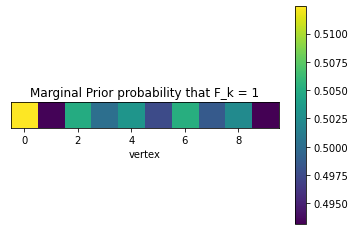

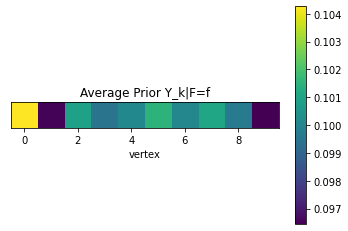

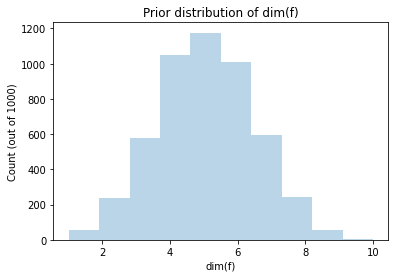

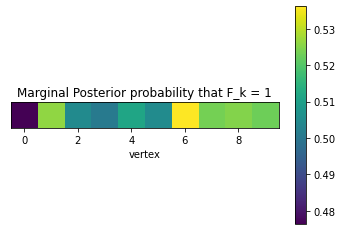

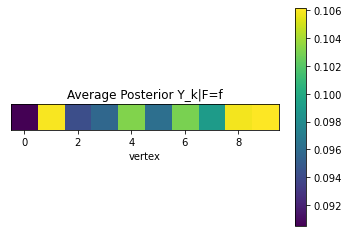

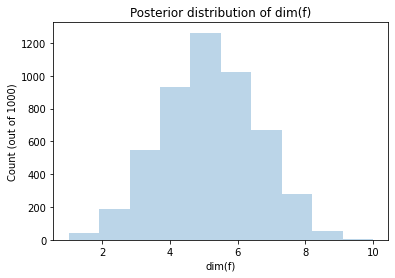

In [24]:
compare_p_q(vae, get_batcher(valid_loader, args), args)

In [25]:
def visualize(vae, batcher: Batcher, args, N=4, num_figs=1): 

    assert N <= args.batch_size, "N should be no bigger than a batch"
    with torch.no_grad():
        vae.p.eval()        
        vae.q.eval()
            
        # Some visualisations
        for r, (x_obs, y_obs) in enumerate(batcher, 1):

            plt.figure(figsize=(2*N, 2*N))
            plt.subplots_adjust(wspace=0.5, hspace=0.5)        
        
            
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)
            x_obs = x_obs[:N]
            # [B, 10]
            context = None
            
            B, K, D = x_obs.shape[0], vae.p._latent_dim, vae.p._data_dim            
            # marginal probability
            prob = vae.estimate_ll_per_bit(x_obs, args.num_samples).exp()            
            # posterior samples
            f, y = vae.q.sample(x_obs)
            x = vae.p.X(y).sample()
            # prior samples
            f_, y_, x_ = vae.p.sample((N,))

            for i in range(N):
                plt.subplot(4, N, 0*N + i + 1)
                plt.imshow(x_obs[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("$x^{(%d)}$" % (i+1))

                plt.subplot(4, N, 1*N + i + 1)
                plt.imshow(x[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("$p(x^{(%d)})$" % (i+1))
                
                plt.subplot(4, N, 2*N + i + 1)                
                plt.axhline(y=args.height//2, c='red', linewidth=1, ls='--')
                plt.imshow(x[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("x|$x^{(%d)}$" % (i+1))
                
                plt.subplot(4, N, 3*N + i + 1)
                plt.imshow(x_[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("x ~ p")
                
            plt.show()

            if r == num_figs:
                break

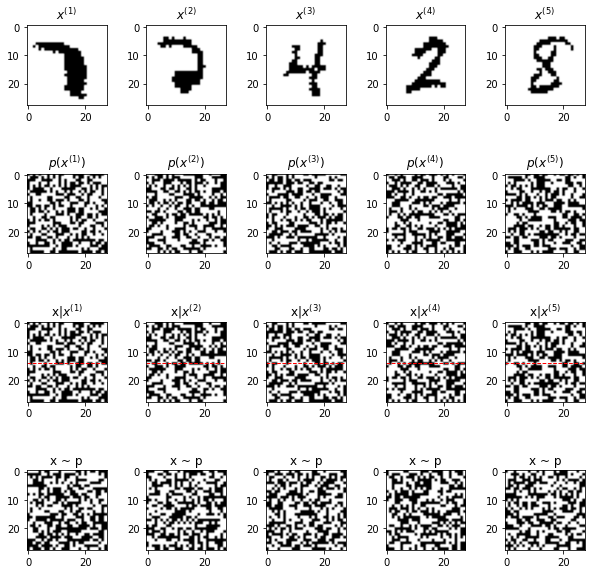

In [26]:
visualize(vae, get_batcher(valid_loader, args), args, N=5)

## Training

In [27]:
def validate(vae, batcher, args):
    """
    Return average NLL and the average number of bits per dimension.
    """
    with torch.no_grad():
        vae.eval()
        
        nb_obs = 0
        nb_bits = 0.
        ll = 0.
        for x_obs, y_obs in batcher:
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)     
            # [B]
            ll = ll + vae.estimate_ll(x_obs, args.num_samples).sum(0)
            nb_bits += np.prod(x_obs.shape)
            nb_obs += x_obs.shape[0]

    nll = - ll / nb_obs
    return nll, nll / np.log(2) / args.latent_dim

In [28]:
from tqdm.auto import tqdm
from itertools import chain
from collections import defaultdict

### Optimiser

In [29]:
p_opt = torch.optim.Adam(p.parameters())
q_opt = torch.optim.Adam(q.parameters())
stats_tr = defaultdict(list)
stats_val = defaultdict(list)

### Steps

In [30]:
val_metrics = validate(vae, get_batcher(valid_loader, args), args)
stats_val['val_nll'].append(val_metrics[0])
stats_val['val_bpd'].append(val_metrics[1])
print(f'Validation {0:3d}: nll={val_metrics[0]:.4f} bpd={val_metrics[1]:.4f}')

for epoch in range(3):

    iterator = tqdm(get_batcher(train_loader, args))

    for x_obs, y_obs in iterator:        
        # [B, H*W]
        x_obs = x_obs.reshape(-1, args.height * args.width)
        # [B, 10]
        context = None   
        
        vae.train()      
        if len(stats_tr['SFE_base_reward_mean']) > 100:  # TODO make hparam
            reward_avg = np.mean(stats_tr['SFE_base_reward_mean'][:-100])
            reward_std = np.mean(stats_tr['SFE_base_reward_std'][:-100])
        else:
            reward_avg, reward_std = 0., 1.
        loss, ret = vae.loss(x_obs, reward_avg, reward_std)

        for k, v in ret.items():
            stats_tr[k].append(v)
                
        p_opt.zero_grad()
        q_opt.zero_grad()        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(
            chain(vae.gen_parameters(), vae.inf_parameters()), 
            args.grad_clip
        )        
        p_opt.step()
        q_opt.step()
    
        iterator.set_description(f'Epoch {epoch+1:3d}')
        iterator.set_postfix(ret)
    
    val_metrics = validate(vae, get_batcher(valid_loader, args), args)
    stats_val['val_nll'].append(val_metrics[0])
    stats_val['val_bpd'].append(val_metrics[1])
    print(f'Validation {epoch:3d}: nll={val_metrics[0]:.4f} bpd={val_metrics[1]:.4f}')


Validation   0: nll=543.5144 bpd=78.4126



Validation   0: nll=185.8830 bpd=26.8173



Validation   1: nll=160.9300 bpd=23.2173



Validation   2: nll=152.3125 bpd=21.9741


### Training Curves

In [31]:
np_stats_tr = {k: np.array(v) for k, v in stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in stats_val.items()}

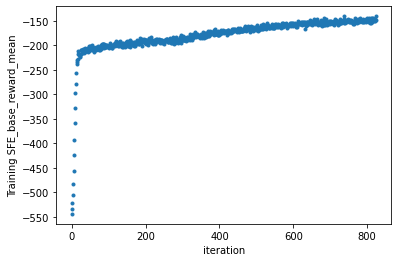

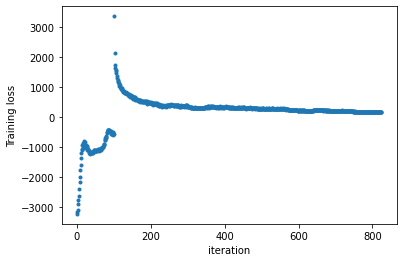

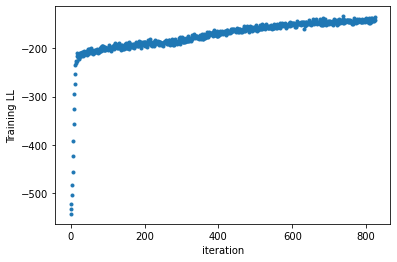

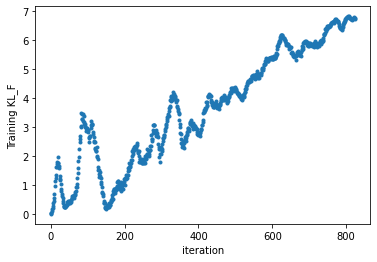

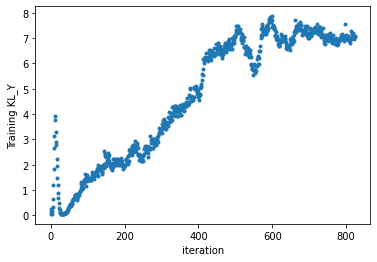

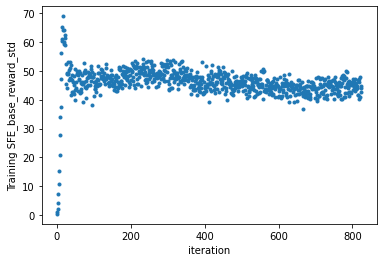

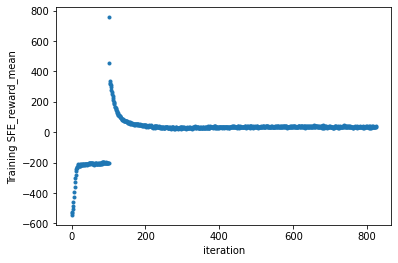

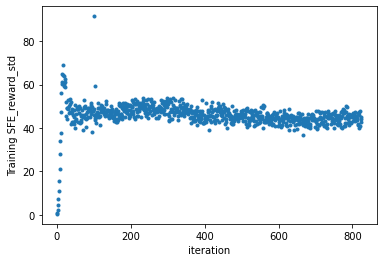

In [32]:
for k, v in np_stats_tr.items():
    plt.plot(np.arange(v.size), v, '.')
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

### Validation Curves

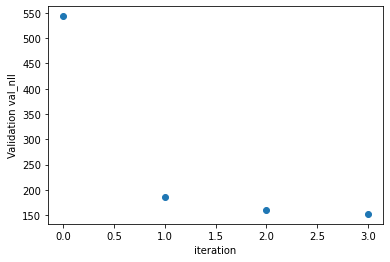

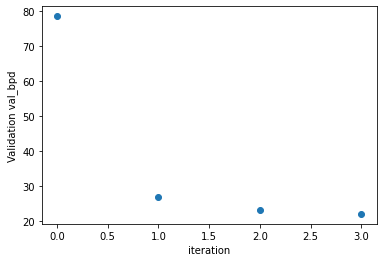

In [33]:
for k, v in np_stats_val.items():
    plt.plot(np.arange(v.size), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('iteration')
    plt.show()

### Analysis

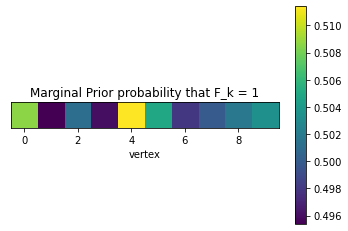

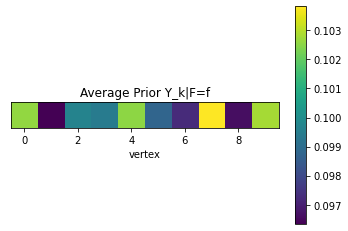

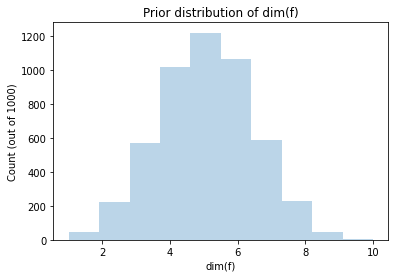

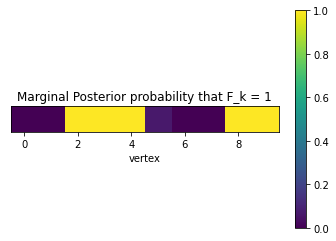

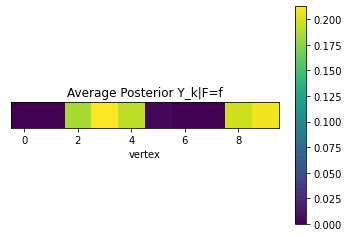

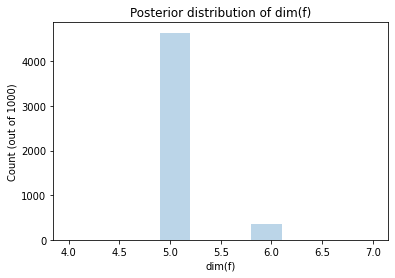

In [34]:
compare_p_q(vae, get_batcher(valid_loader, args), args)

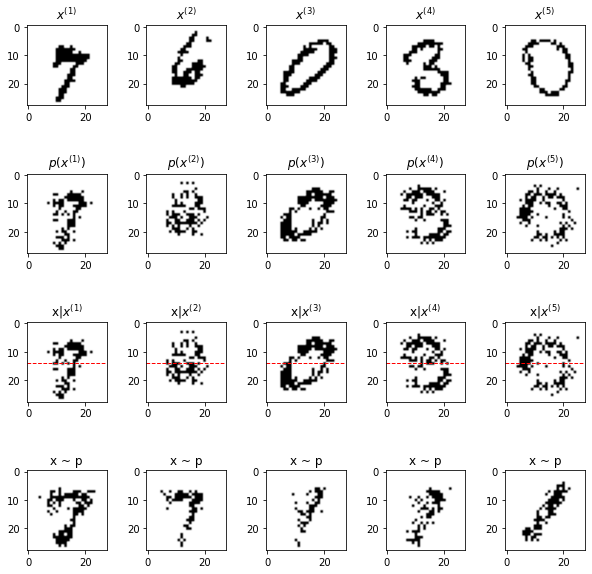

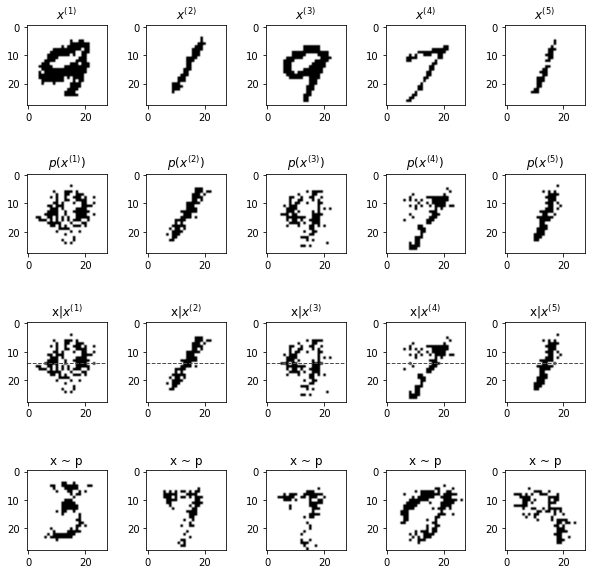

In [35]:
visualize(vae, get_batcher(valid_loader, args), args, N=5, num_figs=2)